# Anomaly Detection using PyOD

This notebook demonstrates anomaly detection using PyOD (Python Outlier Detection) library. We'll explore both univariate and multivariate anomaly detection use cases.

## Overview
- Anomaly detection identifies rare items, events, or observations that differ significantly from the majority
- PyOD provides a comprehensive toolkit for outlier detection
- We'll use multiple algorithms and compare their performance


In [3]:
# Install PyOD (uncomment if needed)
!pip install pyod

# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, average_precision_score
from pyod.models.knn import KNN
from pyod.models.iforest import IForest
from pyod.models.lof import LOF
from pyod.models.ocsvm import OCSVM
from pyod.models.copod import COPOD
from pyod.utils.data import generate_data, evaluate_print
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")


  Using cached pyod-2.0.6-py3-none-any.whl.metadata (46 kB)
Using cached pyod-2.0.6-py3-none-any.whl (204 kB)


## Generate Synthetic Dataset with Anomalies


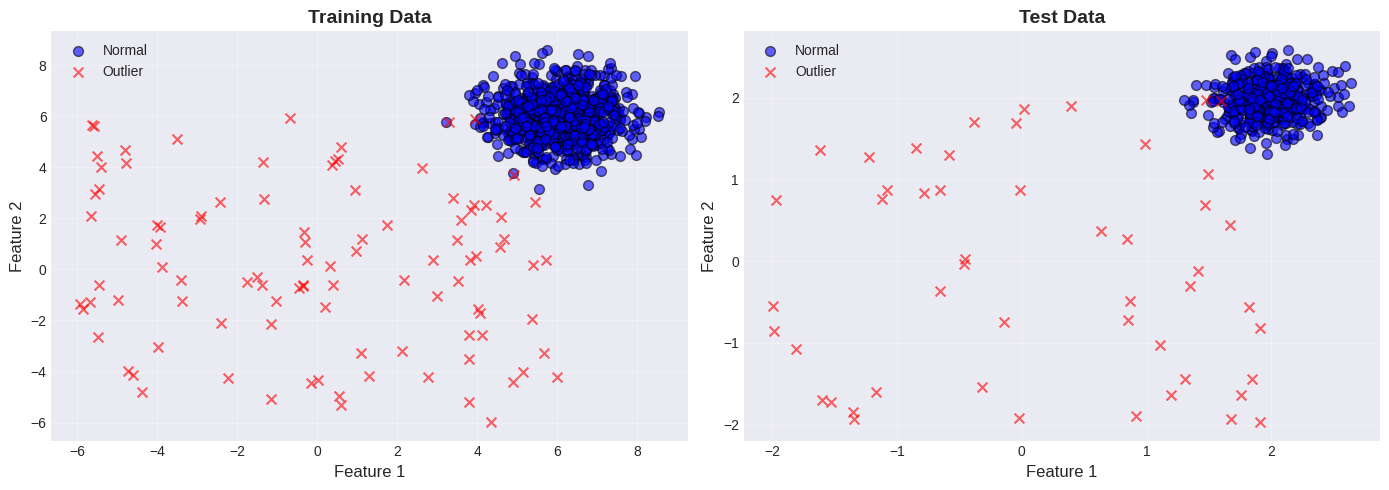

Training set: 1000 samples, 100.0 outliers (10.0%)
Test set: 500 samples, 50.0 outliers (10.0%)


In [6]:
# Generate synthetic data with outliers
X_train, _, y_train, _ = generate_data(n_train=1000, n_test=0, n_features=2,
                                 contamination=0.1, random_state=42)

# Visualize the data
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training data
normal_train = X_train[y_train == 0]
outlier_train = X_train[y_train == 1]

axes[0].scatter(normal_train[:, 0], normal_train[:, 1], c='blue',
               s=50, alpha=0.6, label='Normal', edgecolors='k')
axes[0].scatter(outlier_train[:, 0], outlier_train[:, 1], c='red',
               s=50, alpha=0.6, label='Outlier', edgecolors='k', marker='x')
axes[0].set_title('Training Data', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Feature 1', fontsize=12)
axes[0].set_ylabel('Feature 2', fontsize=12)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Test data
_, X_test, _, y_test = generate_data(n_train=0, n_test=500, n_features=2,
                               contamination=0.1, random_state=123)
normal_test = X_test[y_test == 0]
outlier_test = X_test[y_test == 1]

axes[1].scatter(normal_test[:, 0], normal_test[:, 1], c='blue',
               s=50, alpha=0.6, label='Normal', edgecolors='k')
axes[1].scatter(outlier_test[:, 0], outlier_test[:, 1], c='red',
               s=50, alpha=0.6, label='Outlier', edgecolors='k', marker='x')
axes[1].set_title('Test Data', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Feature 1', fontsize=12)
axes[1].set_ylabel('Feature 2', fontsize=12)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Training set: {X_train.shape[0]} samples, {np.sum(y_train)} outliers ({100*np.sum(y_train)/len(y_train):.1f}%)")
print(f"Test set: {X_test.shape[0]} samples, {np.sum(y_test)} outliers ({100*np.sum(y_test)/len(y_test):.1f}%)")

## Apply Multiple Anomaly Detection Algorithms


In [7]:
# Initialize multiple anomaly detection models
classifiers = {
    'KNN': KNN(contamination=0.1),
    'Isolation Forest': IForest(contamination=0.1, random_state=42),
    'LOF': LOF(contamination=0.1),
    'OCSVM': OCSVM(contamination=0.1),
    'COPOD': COPOD(contamination=0.1)
}

# Train and evaluate each model
results = {}

for name, clf in classifiers.items():
    # Train
    clf.fit(X_train)

    # Predict on test set
    y_test_pred = clf.predict(X_test)
    y_test_scores = clf.decision_function(X_test)

    # Calculate metrics
    roc_auc = roc_auc_score(y_test, y_test_scores)
    ap = average_precision_score(y_test, y_test_scores)

    results[name] = {
        'classifier': clf,
        'predictions': y_test_pred,
        'scores': y_test_scores,
        'roc_auc': roc_auc,
        'average_precision': ap
    }

    print(f"{name}:")
    print(f"  ROC-AUC: {roc_auc:.4f}")
    print(f"  Average Precision: {ap:.4f}")
    print()


KNN:
  ROC-AUC: 0.2365
  Average Precision: 0.0856

Isolation Forest:
  ROC-AUC: 0.9362
  Average Precision: 0.8454

LOF:
  ROC-AUC: 0.0850
  Average Precision: 0.0550

OCSVM:
  ROC-AUC: 0.2587
  Average Precision: 0.2030

COPOD:
  ROC-AUC: 0.9951
  Average Precision: 0.9748



## Visualize Anomaly Detection Results


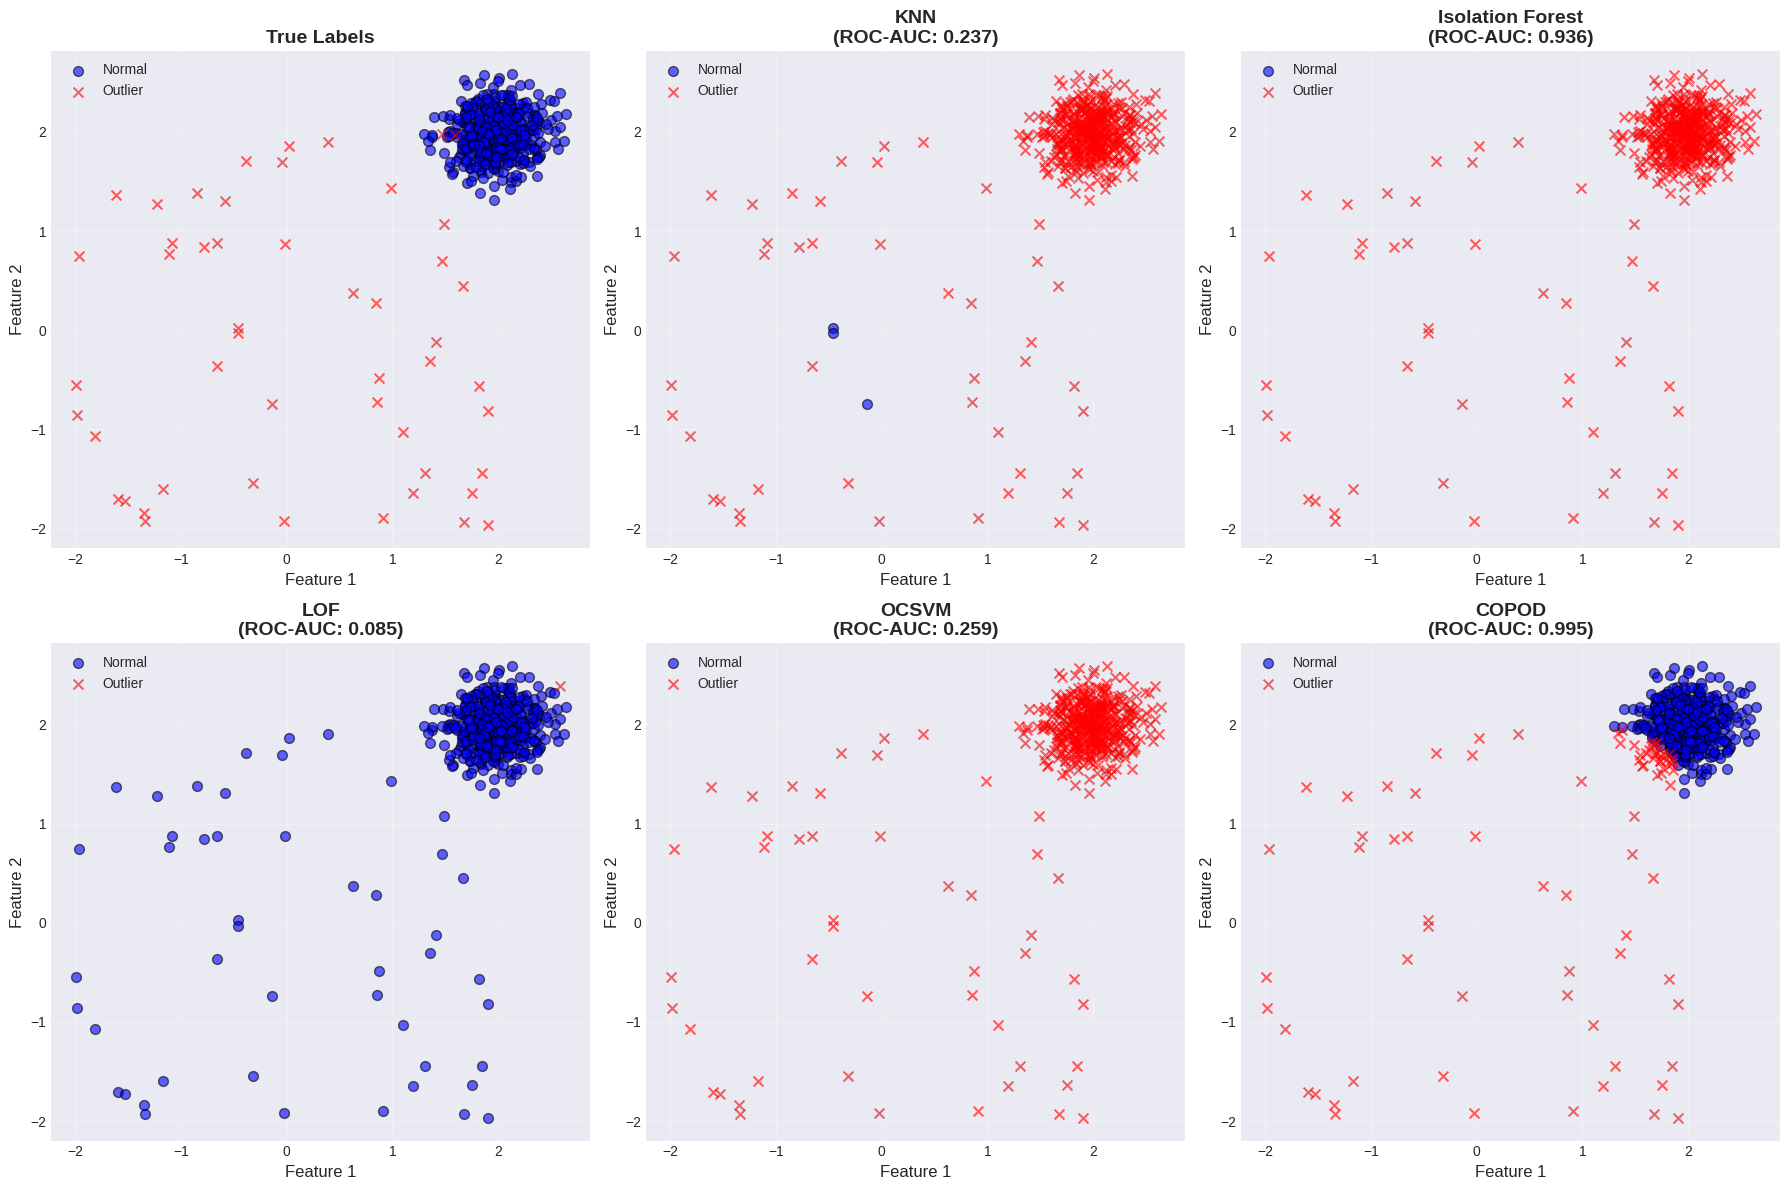

In [8]:
# Visualize results for each algorithm
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

# True labels
normal_test = X_test[y_test == 0]
outlier_test = X_test[y_test == 1]
axes[0].scatter(normal_test[:, 0], normal_test[:, 1], c='blue',
               s=50, alpha=0.6, label='Normal', edgecolors='k')
axes[0].scatter(outlier_test[:, 0], outlier_test[:, 1], c='red',
               s=50, alpha=0.6, label='Outlier', edgecolors='k', marker='x')
axes[0].set_title('True Labels', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Feature 1', fontsize=12)
axes[0].set_ylabel('Feature 2', fontsize=12)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Predictions for each algorithm
for idx, (name, result) in enumerate(results.items(), 1):
    normal_pred = X_test[result['predictions'] == 0]
    outlier_pred = X_test[result['predictions'] == 1]

    axes[idx].scatter(normal_pred[:, 0], normal_pred[:, 1], c='blue',
                     s=50, alpha=0.6, label='Normal', edgecolors='k')
    axes[idx].scatter(outlier_pred[:, 0], outlier_pred[:, 1], c='red',
                     s=50, alpha=0.6, label='Outlier', edgecolors='k', marker='x')
    axes[idx].set_title(f'{name}\n(ROC-AUC: {result["roc_auc"]:.3f})',
                       fontsize=14, fontweight='bold')
    axes[idx].set_xlabel('Feature 1', fontsize=12)
    axes[idx].set_ylabel('Feature 2', fontsize=12)
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Univariate Anomaly Detection Example


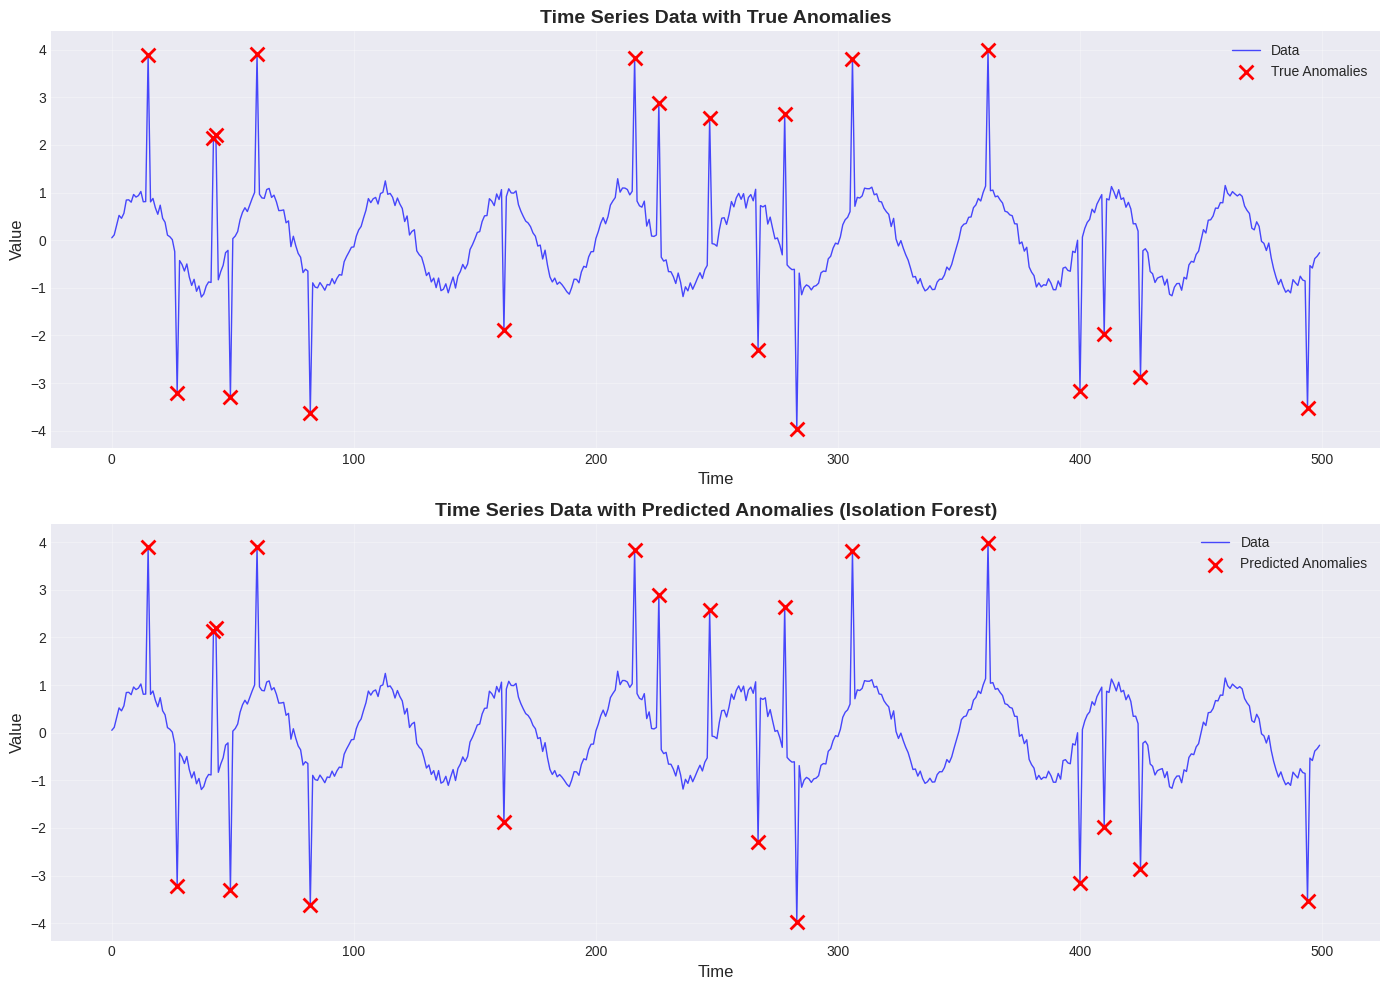

UNIVARIATE ANOMALY DETECTION RESULTS
ROC-AUC Score: 1.0000
Average Precision: 1.0000
True Anomalies: 20.0
Predicted Anomalies: 20


In [9]:
# Generate univariate time series data with anomalies
np.random.seed(42)
n_samples = 500
time = np.arange(n_samples)
normal_data = np.sin(2 * np.pi * time / 50) + np.random.normal(0, 0.1, n_samples)

# Add some anomalies
anomaly_indices = np.random.choice(n_samples, size=20, replace=False)
anomaly_values = normal_data.copy()
anomaly_values[anomaly_indices] += np.random.choice([-3, 3], size=20)

# Create labels
y_univariate = np.zeros(n_samples)
y_univariate[anomaly_indices] = 1

# Reshape for PyOD (needs 2D)
X_univariate = anomaly_values.reshape(-1, 1)

# Apply anomaly detection
iforest_uni = IForest(contamination=0.04, random_state=42)
iforest_uni.fit(X_univariate)
y_pred_uni = iforest_uni.predict(X_univariate)
scores_uni = iforest_uni.decision_function(X_univariate)

# Visualize
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Time series with true anomalies
axes[0].plot(time, anomaly_values, 'b-', alpha=0.7, linewidth=1, label='Data')
axes[0].scatter(time[y_univariate == 1], anomaly_values[y_univariate == 1],
               c='red', s=100, marker='x', linewidths=2, label='True Anomalies', zorder=5)
axes[0].set_title('Time Series Data with True Anomalies', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Time', fontsize=12)
axes[0].set_ylabel('Value', fontsize=12)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Time series with predicted anomalies
axes[1].plot(time, anomaly_values, 'b-', alpha=0.7, linewidth=1, label='Data')
axes[1].scatter(time[y_pred_uni == 1], anomaly_values[y_pred_uni == 1],
               c='red', s=100, marker='x', linewidths=2, label='Predicted Anomalies', zorder=5)
axes[1].set_title('Time Series Data with Predicted Anomalies (Isolation Forest)',
                  fontsize=14, fontweight='bold')
axes[1].set_xlabel('Time', fontsize=12)
axes[1].set_ylabel('Value', fontsize=12)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

roc_auc_uni = roc_auc_score(y_univariate, scores_uni)
ap_uni = average_precision_score(y_univariate, scores_uni)

print("UNIVARIATE ANOMALY DETECTION RESULTS")
print("=" * 50)
print(f"ROC-AUC Score: {roc_auc_uni:.4f}")
print(f"Average Precision: {ap_uni:.4f}")
print(f"True Anomalies: {np.sum(y_univariate)}")
print(f"Predicted Anomalies: {np.sum(y_pred_uni)}")
print("=" * 50)


## Multivariate Anomaly Detection: Real-World Example


MULTIVARIATE ANOMALY DETECTION RESULTS
KNN:
  ROC-AUC: 0.9989
  Average Precision: 0.9828

Isolation Forest:
  ROC-AUC: 0.9999
  Average Precision: 0.9989

LOF:
  ROC-AUC: 0.4551
  Average Precision: 0.0582

OCSVM:
  ROC-AUC: 1.0000
  Average Precision: 1.0000

COPOD:
  ROC-AUC: 1.0000
  Average Precision: 1.0000



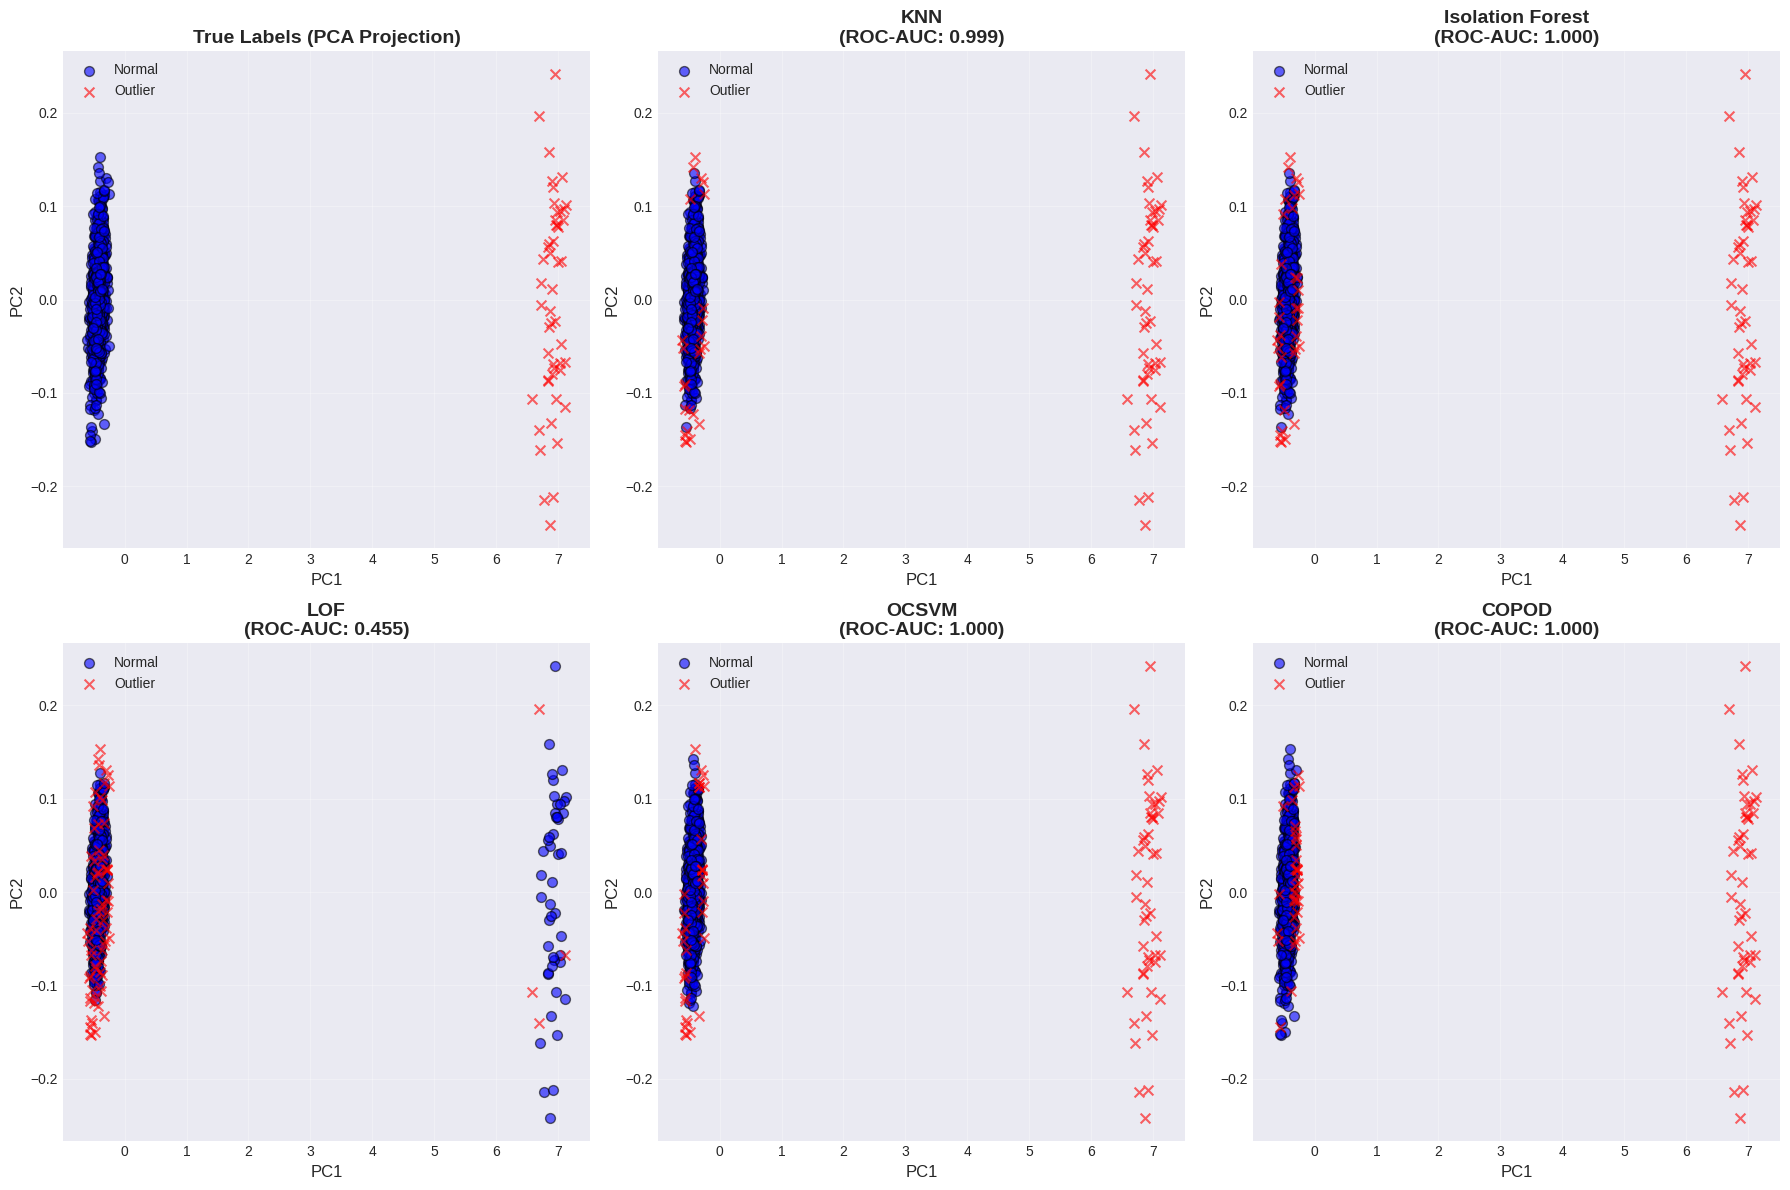

In [12]:
# Create a more realistic multivariate dataset
# Simulating network traffic data with anomalies
np.random.seed(42)
n_normal = 800
n_anomaly = 50

# Normal traffic patterns
normal_traffic = np.random.multivariate_normal(
    mean=[100, 50, 200],
    cov=[[20, 5, 10], [5, 15, 8], [10, 8, 25]],
    size=n_normal
)

# Anomalous traffic (different patterns)
anomaly_traffic = np.random.multivariate_normal(
    mean=[500, 300, 1000],
    cov=[[100, 20, 50], [20, 80, 30], [50, 30, 200]],
    size=n_anomaly
)

X_multivariate = np.vstack([normal_traffic, anomaly_traffic])
y_multivariate = np.hstack([np.zeros(n_normal), np.ones(n_anomaly)])

# Shuffle
shuffle_idx = np.random.permutation(len(X_multivariate))
X_multivariate = X_multivariate[shuffle_idx]
y_multivariate = y_multivariate[shuffle_idx]

# Standardize
scaler = StandardScaler()
X_multivariate_scaled = scaler.fit_transform(X_multivariate)

# Apply multiple algorithms
multivariate_results = {}

# Re-initialize classifiers for the multivariate dataset
multivariate_classifiers = {
    'KNN': KNN(contamination=0.1),
    'Isolation Forest': IForest(contamination=0.1, random_state=42),
    'LOF': LOF(contamination=0.1),
    'OCSVM': OCSVM(contamination=0.1),
    'COPOD': COPOD(contamination=0.1)
}

for name, clf in multivariate_classifiers.items():
    clf.fit(X_multivariate_scaled)
    y_pred_multi = clf.predict(X_multivariate_scaled)
    y_scores_multi = clf.decision_function(X_multivariate_scaled)

    roc_auc_multi = roc_auc_score(y_multivariate, y_scores_multi)
    ap_multi = average_precision_score(y_multivariate, y_scores_multi)

    multivariate_results[name] = {
        'roc_auc': roc_auc_multi,
        'average_precision': ap_multi,
        'predictions': y_pred_multi
    }

# Print results
print("MULTIVARIATE ANOMALY DETECTION RESULTS")
print("=" * 70)
for name, result in multivariate_results.items():
    print(f"{name}:")
    print(f"  ROC-AUC: {result['roc_auc']:.4f}")
    print(f"  Average Precision: {result['average_precision']:.4f}")
    print()
print("=" * 70)

# Visualize using PCA for 2D projection
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_multivariate_scaled)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

# True labels
normal_pca = X_pca[y_multivariate == 0]
outlier_pca = X_pca[y_multivariate == 1]
axes[0].scatter(normal_pca[:, 0], normal_pca[:, 1], c='blue',
               s=50, alpha=0.6, label='Normal', edgecolors='k')
axes[0].scatter(outlier_pca[:, 0], outlier_pca[:, 1], c='red',
               s=50, alpha=0.6, label='Outlier', edgecolors='k', marker='x')
axes[0].set_title('True Labels (PCA Projection)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('PC1', fontsize=12)
axes[0].set_ylabel('PC2', fontsize=12)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

for idx, (name, result) in enumerate(multivariate_results.items(), 1):
    normal_pred = X_pca[result['predictions'] == 0]
    outlier_pred = X_pca[result['predictions'] == 1]

    axes[idx].scatter(normal_pred[:, 0], normal_pred[:, 1], c='blue',
                     s=50, alpha=0.6, label='Normal', edgecolors='k')
    axes[idx].scatter(outlier_pred[:, 0], outlier_pred[:, 1], c='red',
                     s=50, alpha=0.6, label='Outlier', edgecolors='k', marker='x')
    axes[idx].set_title(f'{name}\n(ROC-AUC: {result["roc_auc"]:.3f})',
                       fontsize=14, fontweight='bold')
    axes[idx].set_xlabel('PC1', fontsize=12)
    axes[idx].set_ylabel('PC2', fontsize=12)
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()